In [5]:
import os
import numpy as np
from dtw import dtw
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [6]:
def similarity_DTW(s1, s2):
    ratio = 50 # 设定的放缩系数，避免数据的相似度过于集中
    euclidean_norm = lambda x, y: np.abs(ratio * (x - y))
    d, cost_matrix, acc_cost_matrix, path = dtw(s1, s2, dist=euclidean_norm)
    score = 1 - np.tanh(d)  # 相似度的评分【0,1】 0： 完全不同， 1： 完全相同
    return score

## 1. Cluster 的聚类结果

100%|██████████| 5/5 [00:00<00:00, 44.38it/s]


          0         1         2         3         4
0  1.000000  0.709755  0.624080  0.633916  0.623240
1  0.709755  1.000000  0.742142  0.708771  0.742006
2  0.624080  0.742142  1.000000  0.657583  0.573341
3  0.633916  0.708771  0.657583  1.000000  0.617899
4  0.623240  0.742006  0.573341  0.617899  1.000000
[2, 3, 4, 0, 1]
['ClusterID2', 'ClusterID3', 'ClusterID4', 'ClusterID0', 'ClusterID1']
            ClusterID2  ClusterID3  ClusterID4  ClusterID0  ClusterID1
ClusterID2    1.000000    0.709755    0.624080    0.633916    0.623240
ClusterID3    0.709755    1.000000    0.742142    0.708771    0.742006
ClusterID4    0.624080    0.742142    1.000000    0.657583    0.573341
ClusterID0    0.633916    0.708771    0.657583    1.000000    0.617899
ClusterID1    0.623240    0.742006    0.573341    0.617899    1.000000


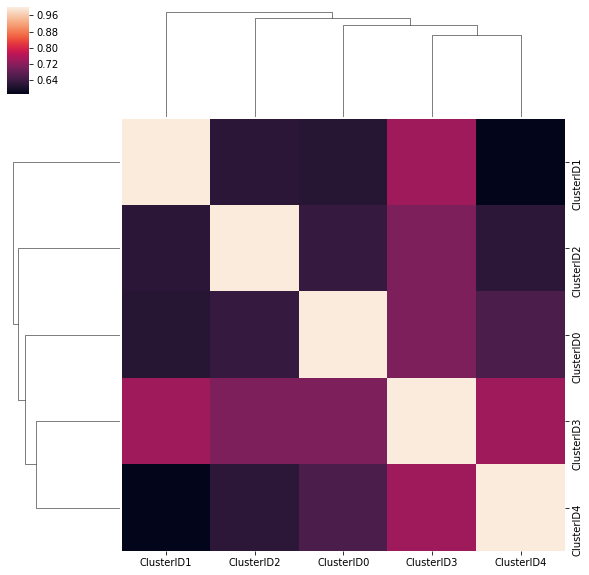

In [7]:
DBA_cluster = np.load("./processing/DBA_wave.pkl", allow_pickle=True)
DBA_clustering_heatmap = np.zeros((len(DBA_cluster), len(DBA_cluster)))
id_list = list(DBA_cluster.keys())
for i, id in enumerate(tqdm(id_list)):
    s1 = DBA_cluster[id]
    for j in range(0, i+1):
        id_2 = id_list[j]
        s2 = DBA_cluster[id_2]
        score = similarity_DTW(s1, s2)
        DBA_clustering_heatmap[i][j] = score
        DBA_clustering_heatmap[j][i] = score
data_frame = pd.DataFrame(DBA_clustering_heatmap)
print(data_frame)

print(id_list)
cluster_id = ["ClusterID{}".format(x) for x in id_list]
print(cluster_id)
cluster_result = data_frame.rename(index=dict(zip(range(len(cluster_id)), cluster_id)), columns=dict(zip(range(len(cluster_id)), cluster_id)))
print(cluster_result)
# print(data_frame)

# metric数据度量方法, method计算聚类的方法
# standard_scale标准维度（0：行或1：列即每行或每列的含义，减去最小值并将每个维度除以其最大值）
sns.clustermap(cluster_result)
# Normalize 正则化
# sns.clustermap(cluster_result, z_score=1)
plt.savefig("./pdf/cluster_heatmap.pdf")
plt.show()

## 2.选择top-10作为cluster谱聚类的结果

          0         1         2         3         4         5         6   \
0   1.000000  0.864046  0.815893  0.854798  0.853269  0.661611  0.668004   
1   0.864046  1.000000  0.800209  0.819497  0.875683  0.798189  0.809382   
2   0.815893  0.800209  1.000000  0.805432  0.806670  0.652091  0.680850   
3   0.854798  0.819497  0.805432  1.000000  0.860047  0.675515  0.694160   
4   0.853269  0.875683  0.806670  0.860047  1.000000  0.624477  0.661695   
5   0.661611  0.798189  0.652091  0.675515  0.624477  1.000000  0.943066   
6   0.668004  0.809382  0.680850  0.694160  0.661695  0.943066  1.000000   
7   0.658174  0.792174  0.647361  0.689089  0.636507  0.960956  0.929293   
8   0.630665  0.789784  0.612784  0.629261  0.593015  0.959267  0.929661   
9   0.653745  0.789999  0.647463  0.668529  0.618627  0.969264  0.939265   
10  0.481085  0.545908  0.533481  0.464131  0.420698  0.572265  0.599432   
11  0.659404  0.677606  0.620714  0.583122  0.540916  0.666417  0.697017   
12  0.486234

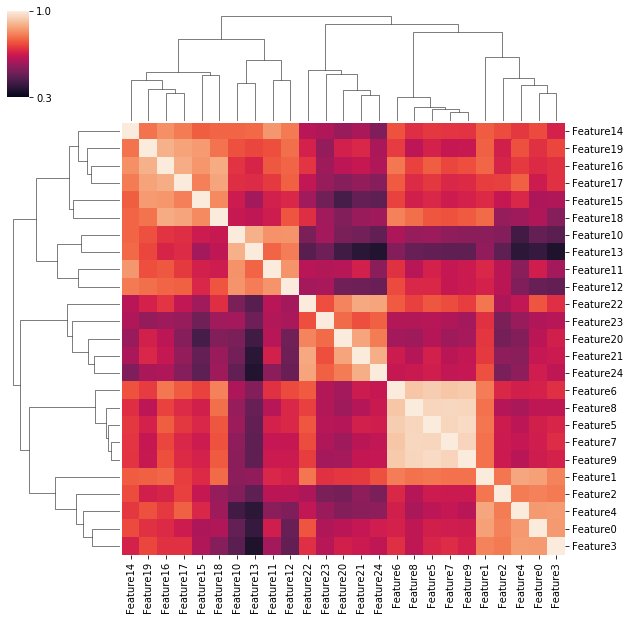

In [8]:
top_cluster_wave_path = "./processing/top_cluater_wave__fid_data.pkl"
wave_clusters_id_feature_data_path = "./processing/wave_clusters_id_feature_data.pkl"

top_cluster_wave = np.load(top_cluster_wave_path, allow_pickle=True)
wave_cluster_wave = np.load(wave_clusters_id_feature_data_path, allow_pickle=True)
# print(wave_cluster_wave)
# print(top_cluster_wave)
cluster_id_list = top_cluster_wave.keys()
feature_ids = []
for c_id in cluster_id_list:
    for f_id, _score in top_cluster_wave[c_id]:
        _tmp_data = wave_cluster_wave[c_id]
        _data, _ids = zip(*_tmp_data)
        fid_data_dict = dict(zip(_ids, _data))
        data = fid_data_dict[f_id]
        feature_ids.append((data, c_id))

# print(feature_ids)

length = len(feature_ids)
heat_map = np.zeros((length, length))
for i in range(length):
    s1, c_id_a = feature_ids[i]
    for j in range(0, i+1):
        s2, c_id_2 = feature_ids[j] 
        score = similarity_DTW(s1, s2)
        heat_map[i][j] = score
        heat_map[j][i] = score    

data_frame = pd.DataFrame(heat_map)
print(data_frame)
# 命名的差异
# cluster_id = []
# cluster_count = {}
# for _, c_id in feature_ids:
#     if c_id not in cluster_count.keys():
#         cluster_count[c_id] = 0
#     name = "ClusterID{}_{}".format(c_id, cluster_count[c_id])
#     cluster_count[c_id] += 1
#     cluster_id.append(name)
cluster_id = []
for x in range(0, length):
    cluster_id.append("Feature{}".format(x))
print(cluster_id)
cluster_result = data_frame.rename(index=dict(zip(range(len(cluster_id)), cluster_id)), columns=dict(zip(range(len(cluster_id)), cluster_id)))
# print(cluster_result)
# print(data_frame)

# metric数据度量方法, method计算聚类的方法
# standard_scale标准维度（0：行或1：列即每行或每列的含义，减去最小值并将每个维度除以其最大值）
sns.clustermap(cluster_result, vmin = 0.3, vmax=1.0,cbar_kws={"ticks":[0.3,1]})
# Normalize 正则化
# sns.clustermap(cluster_result, z_score=1)
plt.savefig("./pdf/cluster_heatmap_top.pdf")
plt.show()